 ### Solve the wave equation and estimate the wave velocity using PINNs (forward problem). 
The goal of the forward problem is to compute the pressure field $p(x,y,t)$ that satisfies the wave equation with source term $s(x,y,t)$,
$$\frac{\partial^2 p}{\partial x^2} + \frac{\partial^2 p}{\partial y^2} - \frac{1}{c^2} \frac{\partial^2 p}{\partial t^2} = s.$$
We start by assuming that the speed of sound in the medium, $c$, is known and constant. Without loss of generality, we define $ s(x,y,t) \equiv 0 $, and introduce the source(s) as an initial perturbation at an early time.  

The inference of $p(x,y,t)$ and $c(x,y)$ can be based on:
- Observed data 
- Initial conditions
- Boundary conditions
- Physics via the undelying PDE

We will use physics-informed neural networks (PINNs) for the task of estimating $p$. 
We start by importing the needed packages and defining a class for the neural network as well as a few auxiliary functions. 

`conda create -n wave_pinn_tutorial python=3`

`conda activate wave_pinn_tutorial`

`conda install jupyter numpy matplotlib tqdm`

`conda install pytorch torchvision torchaudio -c pytorch`

In [1]:
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
from PINNs_util.PINNs_fdiff import solver
from PINNs_util.PINNs_aux import FCN,\
                        xyt_tensor,\
                        pde_residual,\
                        update_lambda,\
                        absorbing_boundary,\
                        rand_colloc,\
                        rand_bound
from PINNs_util.PINNs_plots import plot_train_log_bound,\
                        plot_train_log,\
                        plot_field,\
                        plot_data,\
                        plot_inital_estimation,\
                        plot_estimation

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

### Problem setup
We define a 2+1D domain. The spatial domain is a square of side length $L=5$ km, and the time domain has a duration $T=1.5$ s. The speed of sound is fixed to a constant value, $c=3$ km/s. The source is modelled as a Gaussian pulse of width `gpulse_std`. The source is placed inside the domain, centered at `r_source`.

It is important to scale the dimensions of the domain so that none of the terms in the PDE is very large or very small. For details on this see *section 3. Non-dimensionalization* in [Wang 2023] https://doi.org/10.48550/arXiv.2308.08468 and the book *Scaling of Differential Equations* by Langtangen and Pedersen. 

To simulate the wave propagation, we use a python implementation of the finite difference method based on Hans Petter Langtangen book "Finite Difference Computing with PDEs" https://hplgit.github.io/fdm-book/doc/pub/book/sphinx/index.html. We compute and plot the reference solution.

In [2]:
# define domain
L = 5
T = 1.5
c = 3

# scaling
T = T*c/L
L = L/L
c = 1

In [3]:
# simulation
Lx, Ly = L, L
Nx, Ny = 30, 30
dt = -1

# initial condition
def I(x, y):
    gpulse_std = 5e-2
    r_source = np.array([0.3, 0.3])
    I = np.exp(-0.5*( ((x-r_source[0])/gpulse_std)**2 +\
                      ((y-r_source[1])/gpulse_std)**2 ))
    return I

# solve
p_ref, x, y, t, dt = solver(I, 0, 0, c, Lx, Ly, Nx, Ny, dt, T)
p_ref, x, y, t = p_ref.astype(np.float32), x.astype(np.float32), y.astype(np.float32), t.astype(np.float32)

# we need tensors
xx, yy = np.meshgrid(x, y)
xy = np.column_stack((np.reshape(xx,(-1,1)), np.reshape(yy,(-1,1))))
r_ref = xyt_tensor(xy, t, device)
n_T = t.shape[0]
n_L = x.shape[0]

# plot reference field (it might take a few seconds)
ani = plot_field(p_ref, L, 'reference pressure')
ani

100%|██████████| 37/37 [00:00<00:00, 5489.93it/s]


### Generate data
We now define the observed data used for estimating the field. Our data will the pressure field on a number of points alinged with the x-axis (black triangles in the left figure). The observed data, called `p_data`, is shown in the rigth figure.
In addition, we assume that we know the position, propagation direction, and shape of the source. This is enconded in two early-time snapshots (see [Rasht-Behesht 2022] https://doi.org/10.1029/2021JB023120). We will call those two spnashots `p_ini`. With this information we are ready to train our PINN. 

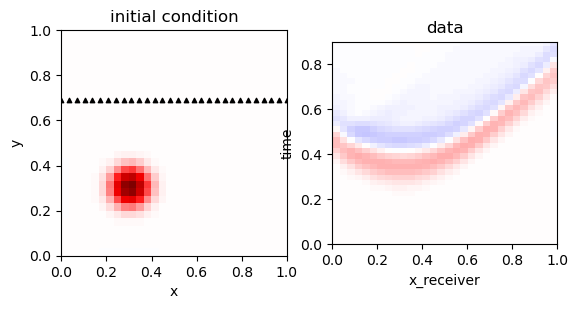

In [4]:
i_data = 20
x_data = xx[i_data,:]
y_data = yy[i_data,:]
xy_data = np.column_stack((x_data, y_data))
r_data = xyt_tensor(xy_data, t, device)
p_data = torch.tensor(p_ref[i_data,:,:])

# Plot data
plot_data(p_ref, p_data, x_data, y_data, L, T)

p_data = p_data.to(device)

# Initial condition
t_ini = t[0:2]
r_ini = xyt_tensor(xy, t_ini, device)
p_ini = p_ref[:,:,0:2].reshape(-1,2)
p_ini = torch.tensor(p_ini, device=device)

### PINN
We start with a fully-connected neural network with 3 inputs, $(x,y,t)$, and 1 output, $p$. We define the number of hidden units per layer, `n_hidden`, and the number of layers, `n_layers`. 

 #### Fourier features
 Neural networks (not only PINNs) struggle to learn the high-frequency content of functions. This is sometmes called the NN 'spectral bias'. High-frequencies can be associated, for example, to function discontinuities or jumps, such as edges in an image (here are some great examples in image processing https://bmild.github.io/fourfeat/). In order to alleviate this issue [Tancik 2020]
 https://doi.org/10.48550/arXiv.2006.10739 proposed a simple Fourier mapping $\gamma(\mathbf{r})$ of the inputs of the network. Later on, Fourier features have also been applied to PINNs to approximate solutions to PDEs with high frequencies and multi-scale features [Wang 2021b] https://doi.org/10.1016/j.cma.2021.113938 In its original formulation, the Fourier mapping is computed as

 $$ \gamma(\mathbf{r}) = \begin{bmatrix} \cos(\mathbf{Br})\\ \sin(\mathbf{Br})\end{bmatrix} $$

where $\mathbf{B}$ is a matrix with dimensions `n_in` x `n_ffeatures`. The entries of $\mathbf{B}$ are sampled from a normal distribution with std $\sigma$.  It was shown, however, that the choice of $\sigma$ is not straight forward since it depends on the frequency content of the function that we want to approximate. Here we change the formulation slightly, and compute the Fourier mapping as 

 $$ \gamma(\mathbf{r}) = \cos(\mathbf{Br + b}) $$

 where $\mathbf{B}$ and $\mathbf{b}$ are treated as network parameters so that they will be learned during training . Note that this is very similar to the SIREN activation function. In our case we just apply it to the input as a first layer.

 To test the Fourier features let's train the network only on the initial conditions. Notice that we *know* the first two of snapshots so the network shouldn't have much trouble learning that. Lets train first a network without Fourier mapping.  

 34%|███▍      | 1030/3000 [00:02<00:06, 316.44it/s]

[ 1000] loss: 4.146*1e-3


 68%|██████▊   | 2053/3000 [00:04<00:01, 564.04it/s]

[ 2000] loss: 3.818*1e-3


100%|██████████| 3000/3000 [00:06<00:00, 441.37it/s]


[ 3000] loss: 2.952*1e-3


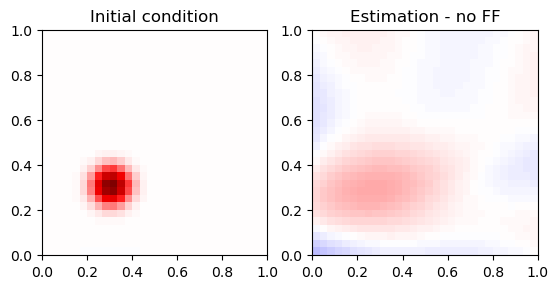

In [5]:
n_in = 3
n_out = 1
n_ffeatures = 0
n_hidden = 64
n_layers = 3
n_epochs = int(3e3)
lamb = [1] # initialise lambdas

model = FCN(n_in, n_out, n_ffeatures, n_hidden, n_layers)
model = model.to(device)

mse_loss = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=1e-4)

for i in tqdm(range(n_epochs)):
    optimiser.zero_grad()
    
    # initial condition loss
    p = model(r_ini)
    p = p.reshape(-1, 2)
    loss_ini = mse_loss(p, p_ini)

    # backpropagate
    loss_ini.backward()
    optimiser.step()

    # print loss
    if i % 1000 == 999:
        print('[%5d] loss: %.3f*1e-3' %
        (i + 1, loss_ini.item()*1e3))

# Plot reference and estimation
p_est = model(r_ini)
p_est = np.reshape(p_est.cpu().detach().numpy(), (-1, 2))
plot_inital_estimation(p_ref, p_est, L)

It's clear that after 3000 epochs the NN has only learned the low frequency content of the initial conditions.
Let's see what happens when we use the Fourier mapping. 

 37%|███▋      | 1106/3000 [00:01<00:02, 764.22it/s]

[ 1000] loss: 0.253*1e-3


 71%|███████   | 2134/3000 [00:03<00:01, 786.61it/s]

[ 2000] loss: 0.089*1e-3


100%|██████████| 3000/3000 [00:04<00:00, 670.95it/s]


[ 3000] loss: 0.027*1e-3


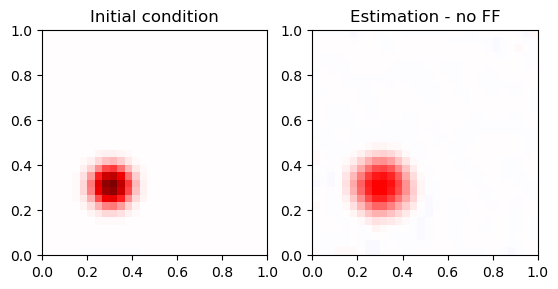

In [6]:
n_ffeatures = 64

model = FCN(n_in, n_out, n_ffeatures, n_hidden, n_layers)
model = model.to(device)

mse_loss = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=1e-4)

for i in tqdm(range(n_epochs)):
    optimiser.zero_grad()
    
    # initial condition loss
    p = model(r_ini)
    p = p.reshape(-1, 2)
    loss_ini = mse_loss(p, p_ini)

    # backpropagate
    loss_ini.backward()
    optimiser.step()

    # print loss
    if i % 1000 == 999:
        print('[%5d] loss: %.3f*1e-3' %
        (i + 1, loss_ini.item()*1e3))

# Plot reference and estimation
p_est = model(r_ini)
p_est = np.reshape(p_est.cpu().detach().numpy(), (-1, 2))
plot_inital_estimation(p_ref, p_est, L)

One can see that the Fourier mapping helps to estimate the high frequencies present in the initial condition.
### Loss function
The loss function $\mathcal{L}$ is defined as a weighted sum of a data term, $\mathcal{L}_\text{data}$, a physics term, $\mathcal{L}_\text{pde}$, and an initial condition term, $\mathcal{L}_\text{ini}$, such that
$$ \mathcal{L} = \lambda_\text{data}\mathcal{L}_\text{data} + \lambda_\text{pde}\mathcal{L}_\text{pde} + \lambda_\text{ini}\mathcal{L}_\text{ini}.$$
Of course, one can also define a loss term for the boundary conditions (BCs) in the same manner, but we don't have BCs here, so we leave it out for now. This is a 'soft-constrained' formulation, meaning that the conditions (data, initial, boundary) are not enforced in a hard way. This soft-constrained PINN is easy to formulate, but on the downside the learned function might not satisfy the conditions exactly.

The choice of the weights $\lambda = [\lambda_\text{data}, \lambda_\text{pde}, \lambda_\text{ini}]$ can be a delicate one. One can choose it 'manually' by trying out different values and keeping the one that give reasonable results. However manually finding a $\lambda$ that balances the relative weight of the loss terms properly can be very tricky and tedious (specially when we have a loss composed by more than two terms). 

Here we implement an anneling algorithm to automatically choose $\lambda$, as proposed in [Wang 2021] https://doi.org/10.48550/arXiv.2001.04536. PINNs are notoriously difficult to train, one of the reasons being that the gradients (wrt to the network parameters $\theta$) of the different terms in the loss function can be very different. This unbalance can lead to unstable gradient descent during traning. As a way to alleviate this, $\lambda$ is chosen based on the gradient of each of the loss terms.
The algorithm is summarized as: 

if (`i_epoch` mod `n_lamb_update`) = 0 compute:
$$ \hat{\lambda}_\text{data} = \frac{||\nabla_\theta \mathcal{L}_\text{data}|| + ||\nabla_\theta \mathcal{L}_\text{pde}|| + ||\nabla_\theta \mathcal{L}_\text{ini}|| } {||\nabla_\theta \mathcal{L}_\text{data}||} $$

$$ \hat{\lambda}_\text{pde} = \frac{||\nabla_\theta \mathcal{L}_\text{data}|| + ||\nabla_\theta \mathcal{L}_\text{pde}|| + ||\nabla_\theta \mathcal{L}_\text{ini}|| } {||\nabla_\theta \mathcal{L}_\text{pde}||} $$

$$ \hat{\lambda}_\text{ini} = \frac{||\nabla_\theta \mathcal{L}_\text{data}|| + ||\nabla_\theta \mathcal{L}_\text{pde}|| + ||\nabla_\theta \mathcal{L}_\text{ini}|| } {||\nabla_\theta \mathcal{L}_\text{ini}||} $$
Then update the weights using a moving average with parameter $\alpha$:
$$ \lambda_\text{new} = \alpha \lambda_\text{old} + (1-\alpha)\hat{\lambda}_\text{new}$$
We also set a $\lambda_\text{max}$ so that $ \lambda = \min\{\lambda_\text{new}, \lambda_\text{max}\}$
 to avoid that it grows unbounded. 

In [7]:
n_in = 3
n_out = 1
n_ffeatures = 64
n_hidden = 64
n_layers = 3
n_lamb_update = 100
n_colloc = 5e3
n_epochs = int(3e4)
lamb = [1, 1, 1]

model = FCN(n_in, n_out, n_ffeatures, n_hidden, n_layers)
model = model.to(device)

mse_loss = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=1e-4)

loss_data_hist = []
loss_pde_hist = []
loss_ini_hist = []
lamb_data_hist = []
lamb_pde_hist = []
lamb_ini_hist = []

In [8]:
for i in tqdm(range(n_epochs)):
    optimiser.zero_grad()
    
    # initial condition loss
    p = model(r_ini)
    p = p.reshape(-1, 2)
    loss_ini = mse_loss(p, p_ini)

    # data loss
    p = model(r_data)
    p = p.reshape(-1, n_T)
    loss_data = mse_loss(p, p_data)

    r_colloc = rand_colloc(n_colloc, L, T, device)

    # pde loss
    p = model(r_colloc)
    pde_res = pde_residual(p, r_colloc, c)
    loss_pde = mse_loss(pde_res, torch.zeros_like(p))

    loss_lst = [loss_data, loss_pde, loss_ini]

    # get gradients and update lambda
    if i % n_lamb_update == 0: 
        lamb = update_lambda(model, loss_lst, lamb, 0.9)

    # total loss
    loss = loss_data + loss_pde*lamb[1]/lamb[0] + loss_ini*lamb[2]/lamb[0] 

    # backpropagate
    loss.backward()
    optimiser.step()

    # log
    loss_data_hist.append(loss_data.item())
    loss_pde_hist.append(loss_pde.item())
    loss_ini_hist.append(loss_ini.item())
    lamb_data_hist.append(lamb[0].item())
    lamb_pde_hist.append(lamb[1].item())
    lamb_ini_hist.append(lamb[2].item())

    # print loss
    if i % 1000 == 999:
        print('[%5d] loss: %.3f*1e-3' %
        (i + 1, loss.item()*1e3))

  0%|          | 0/30000 [00:00<?, ?it/s]

  2%|▏         | 513/30000 [00:07<07:01, 69.95it/s]


KeyboardInterrupt: 

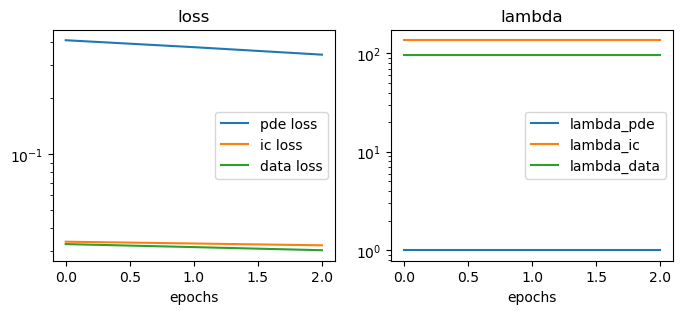

In [9]:
# Plot loss and lambda
plot_train_log(loss_data_hist,\
                loss_ini_hist,\
                loss_pde_hist,\
                lamb_data_hist,\
                lamb_ini_hist,\
                lamb_pde_hist)

In [10]:
# Plot reference and estimation
p_est = model(r_ref)
p_est = np.reshape(p_est.cpu().detach().numpy(), (-1, n_T))
ani = plot_estimation(p_ref, p_est, L)
ani

As we leaned a continuous function, we can estimate the pressure at arbitrary $x,y,t$ in the domain. 

In [11]:
t_hr = np.linspace(0, T, n_T*3).astype(np.float32)
r_hr = np.linspace(0, L, n_L*3).astype(np.float32)

x_hr, y_hr = np.meshgrid(r_hr, r_hr)
r_hr = np.column_stack((np.reshape(x_hr,(-1,1)), np.reshape(y_hr,(-1,1))))
r_hr = xyt_tensor(r_hr, t_hr, device)

p_est = model(r_hr)
p_est = np.reshape(p_est.cpu().detach().numpy(), (n_L*3, n_L*3, n_T*3))
ani = plot_field(p_est, L, 'high res estimation')
ani

###  Absorbing Boundary Conditions (ABCs)
We can see that the constraints (observed data, initial condition and PDE) are satisfied but the resulting wavefield is not what we expected. There is a non-causal wave propagating from outside the domain. 
To account for physical causality during training, time domain decompositions ([Ren 2024], https://doi.org/10.1016/j.cpc.2023.109010) and time-weighting schemes ([Wang 2024] https://doi.org/10.1016/j.cma.2024.116813) have been proposed. 

Before getting into that, let's try to constrain the problem more by adding addional BCs. This might help with the problem conditioning. In particular, ABCs can be very useful in semi-infinite domains as there won't be reflected waves coming from outside the domain. 
We implemented a first-order Clayton and Engquist ABC (see [Gao 2015] https://doi.org/10.1071/EG15068).


In [9]:
lamb = [1, 1, 1, 1]
n_bound = 1e2
n_epochs = int(3e4)
model = FCN(n_in, n_out, n_ffeatures, n_hidden, n_layers)
model = model.to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=1e-4)

loss_data_hist = []
loss_pde_hist = []
loss_ini_hist = []
loss_bound_hist = []
lamb_data_hist = []
lamb_pde_hist = []
lamb_ini_hist = []
lamb_bound_hist = []

In [10]:
for i in tqdm(range(n_epochs)):
    optimiser.zero_grad()
    
    # initial condition loss
    p = model(r_ini)
    p = p.reshape(-1, 2)
    loss_ini = mse_loss(p, p_ini)

    # absorbing boundary conditions 
    loss_bound = torch.zeros_like(loss_ini).requires_grad_(True)
    for j in range(4):
        r_bound = rand_bound(j+1, n_bound, L, T, device)
        p = model(r_bound)
        res_bound = absorbing_boundary(p, r_bound, j+1, c)
        loss_bound = loss_bound + mse_loss(res_bound, torch.zeros_like(res_bound))

    # data loss
    p = model(r_data)
    p = p.reshape(-1, n_T)
    loss_data = mse_loss(p, p_data)

    # pde loss
    r_colloc = rand_colloc(n_colloc, L, T, device)
    p = model(r_colloc)
    pde_res = pde_residual(p, r_colloc, c)
    loss_pde = mse_loss(pde_res, torch.zeros_like(p))

    loss_lst = [loss_data, loss_pde, loss_ini, loss_bound]

    # get gradients and update lambda
    if i % n_lamb_update == 0: 
        lamb = update_lambda(model, loss_lst, lamb, 0.9)

    # total loss
    loss = loss_data + loss_pde*lamb[1]/lamb[0] + loss_ini*lamb[2]/lamb[0] + loss_bound*lamb[3]/lamb[0] 

    # backpropagate
    loss.backward()
    optimiser.step()

    # log
    loss_data_hist.append(loss_data.item())
    loss_pde_hist.append(loss_pde.item())
    loss_ini_hist.append(loss_ini.item())
    loss_bound_hist.append(loss_bound.item())
    lamb_data_hist.append(lamb[0].item())
    lamb_pde_hist.append(lamb[1].item())
    lamb_ini_hist.append(lamb[2].item())
    lamb_bound_hist.append(lamb[3].item())

    # print loss
    if i % 1000 == 999:
        print('[%5d] loss: %.3f*1e-3' %
        (i + 1, loss.item()*1e3))

  3%|▎         | 1007/30000 [00:24<08:41, 55.55it/s]

[ 1000] loss: 3.290*1e-3


  7%|▋         | 2002/30000 [00:54<17:12, 27.10it/s]

[ 2000] loss: 2.229*1e-3


 10%|█         | 3001/30000 [01:17<09:41, 46.43it/s]

[ 3000] loss: 1.713*1e-3


 13%|█▎        | 4002/30000 [01:42<20:53, 20.74it/s]

[ 4000] loss: 1.297*1e-3


 17%|█▋        | 5007/30000 [02:10<10:36, 39.24it/s]

[ 5000] loss: 1.033*1e-3


 20%|██        | 6006/30000 [02:37<08:50, 45.27it/s]

[ 6000] loss: 0.830*1e-3


 23%|██▎       | 7005/30000 [03:05<06:41, 57.21it/s]

[ 7000] loss: 0.666*1e-3


 27%|██▋       | 8011/30000 [03:26<05:51, 62.57it/s]

[ 8000] loss: 0.581*1e-3


 30%|███       | 9001/30000 [03:51<14:21, 24.37it/s]

[ 9000] loss: 0.410*1e-3


 33%|███▎      | 10001/30000 [04:15<07:24, 45.03it/s]

[10000] loss: 0.330*1e-3


 37%|███▋      | 11008/30000 [04:43<09:10, 34.48it/s]

[11000] loss: 0.266*1e-3


 40%|████      | 12007/30000 [05:07<05:06, 58.78it/s]

[12000] loss: 0.209*1e-3


 43%|████▎     | 13009/30000 [05:33<06:30, 43.51it/s]

[13000] loss: 0.304*1e-3


 47%|████▋     | 14001/30000 [05:59<08:58, 29.73it/s]

[14000] loss: 0.194*1e-3


 50%|█████     | 15005/30000 [06:25<04:21, 57.37it/s]

[15000] loss: 0.184*1e-3


 53%|█████▎    | 16006/30000 [06:45<05:44, 40.61it/s]

[16000] loss: 0.120*1e-3


 57%|█████▋    | 17001/30000 [07:08<03:32, 61.06it/s]

[17000] loss: 0.197*1e-3


 60%|██████    | 18001/30000 [07:33<07:56, 25.20it/s]

[18000] loss: 0.214*1e-3


 63%|██████▎   | 19010/30000 [07:59<03:14, 56.53it/s]

[19000] loss: 0.258*1e-3


 67%|██████▋   | 20003/30000 [08:26<07:01, 23.73it/s]

[20000] loss: 0.087*1e-3


 70%|███████   | 21008/30000 [08:52<03:51, 38.81it/s]

[21000] loss: 0.133*1e-3


 73%|███████▎  | 22002/30000 [09:16<05:27, 24.40it/s]

[22000] loss: 0.186*1e-3


 77%|███████▋  | 23001/30000 [09:46<02:14, 52.10it/s]

[23000] loss: 0.155*1e-3


 80%|████████  | 24010/30000 [10:10<01:40, 59.39it/s]

[24000] loss: 0.141*1e-3


 83%|████████▎ | 25001/30000 [10:36<03:42, 22.47it/s]

[25000] loss: 0.106*1e-3


 87%|████████▋ | 25999/30000 [11:03<01:22, 48.37it/s]

[26000] loss: 0.207*1e-3


 90%|█████████ | 27007/30000 [11:26<00:51, 58.56it/s]

[27000] loss: 0.141*1e-3


 93%|█████████▎| 28004/30000 [11:53<01:05, 30.36it/s]

[28000] loss: 0.154*1e-3


 97%|█████████▋| 29008/30000 [12:17<00:16, 60.36it/s]

[29000] loss: 0.065*1e-3


100%|██████████| 30000/30000 [12:43<00:00, 39.31it/s]

[30000] loss: 0.089*1e-3


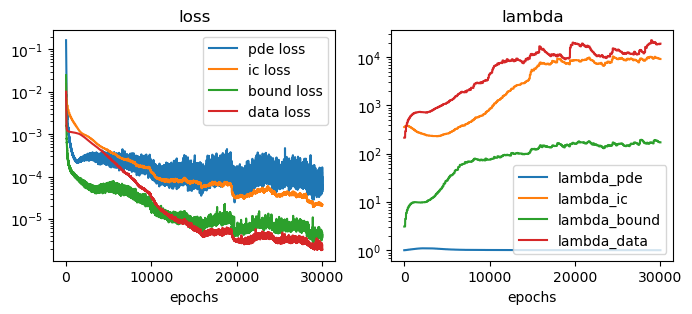

In [11]:
# Plot loss and lambda
plot_train_log_bound(loss_data_hist,\
                    loss_ini_hist,\
                    loss_pde_hist,\
                    loss_bound_hist,\
                    lamb_data_hist,\
                    lamb_ini_hist,\
                    lamb_pde_hist,\
                    lamb_bound_hist)

In [12]:
# Plot reference and estimation
p_est = model(r_ref)
p_est = np.reshape(p_est.cpu().detach().numpy(), (-1, n_T))
ani = plot_estimation(p_ref, p_est, L)
ani